So far we have only discussed models that deal with answering the question: "based on the previous trends, if the new datapoint is $\vec{v} = (1, 2, 3)$ what should be its corresponding prediction, $P$?"

- These are models that specialize in predicting a continuous output for a series of continuous inputs.

However, these models are unable to answer questions regarding classification!

Ex: "Does this image show a picture of dog or a cat?"

1) How do we define set of inputs would appropriately represent an animal (cat / dog)?

2) What would be the threshold at or line of separation that makes the input a cat or a dog, and what if an input lands exactly on that line?

**One way to handle this problem is create a model that generates a probability of the input being a cat (or not being a cat). In other words we want to find a model that is appropriate for binary classification.**

Input: $n$ features per datapoint

Output: Some probability $(0, 1)$

Instead of making a new prediction model, lets see if we can manipulate the output of linear regression to generate a probability.

Linear regression: $z = w_1x_1 + w_2x_2 + ... + w_nx_n + b$ (per datapoint)

We want some function $f$ that maps the linear regression output to some probability $(0, 1)$. This function should be smooth and continuous, and should be differentiable across all possible input values.

A popular choice is the sigmoid function: $f(z) = \frac{1}{1 + e^{-z}}$

Another choice is the ReLU function: $f(z) = \max(0, z)$

Below are the graphical representations of the sigmoid and ReLU functions.

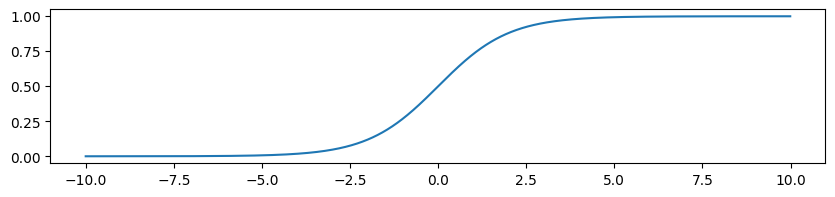

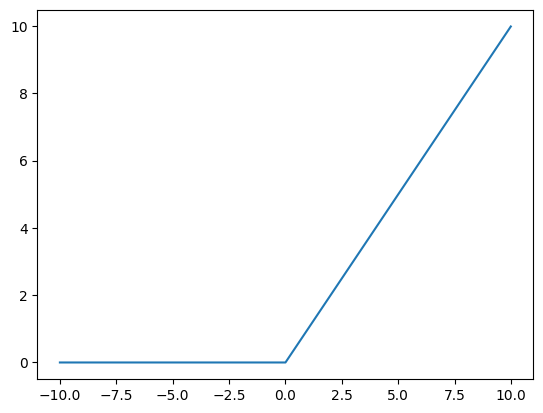

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Graph of sigmoid function

x = np.arange(-10, 10, 0.01)
y = 1 / (1 + np.exp(-x))

# Ensure that plot is representative (make plot wide to show the smoothness of the curve)
plt.figure(figsize=(10,2))

plt.plot(x, y)
plt.show()

# Graph of Relu function

x = np.arange(-10, 10, 0.01)
y = np.maximum(0, x)

plt.plot(x, y)
plt.show()

While the Relu function isn't "smooth" nor is it limited at an output range of $[0, 1]$, we can clip the output to $[0, 1]$ artifically and place coefficents on the linear part of the function to make its slope configurable.

**However we will stick with using the sigmoid function for now.**

Note that the actual model will kind of resemble a step function because it will only have two possible outputs (either 0 or 1) but the sigmoid function will output a value between 0 and 1.

<img src="./media/sigmoid_mapping.png" alt="drawing" width="400">

In the image above the green datapoints are the actual outputs of the data and the predictions made by the sigmoid function will not ever be exactly 0 or 1!

The possible actual outputs are 0 (false) and 1 (true). The actual predictions can be modeled via a binomial distribution.

---

#### Lets review the binomial distribution really quick:

Suppose you have a single coin that can land on heads or tails. The probability of each outcome is $p = 0.5$.

- What is the probability of landing heads 2 times in a row?

$$p_H \cdot p_H = 0.5 \cdot 0.5 = 0.25$$

- What is the probability of landing heads 5 times in a row?

$$p_H^5 = 0.5^5 = 0.03125$$

- What about 2 heads followed by 2 tails?

$$p_H^2 (1 - p_H)^2 = 0.5^2 \cdot 0.5^2 = 0.0625$$

So in general the binomial distribution states that the probability of any sequence of outcomes is: $$p^k (1 - p)^{n - k}$$

---

What if instead of several trials, we simply have one trial, what does the formula for the binomial distribution look like?

$$p^k (1 - p)^{n - k} = p^k \cdot (1 - p)^{1 - k}$$

- If that trial is a sucess then $k = 1$, and the $1 - p$ term becomes a simple 1 (it does not contribute to the overall probability).
- If that trial is a failure then $k = 0$, and the $p$ term becomes a simple 1 (it does not contribute to the overall probability).

**In classification tasks we treat each prediction as a single trial distribution, and $k$ is the actual outcome of the trial. The predicted probability of success and failure are plugged into $p$ and $1 - p$ respectively.**

- Let $\hat{y}$ be the output from the sigmoid function (the probability of true, the output equalling 1 based on the model).
- Then $1 - \hat{y}$ is the probability of the "False" outcome (the probability of the output equalling 0 based on the model).
- Let $y$ and $1 - y$ be the actual output and the opposite of the actual output respectively.

Then for a single training datapoint the likelihood of observing the actual prediction given the predicted probability is:

$$\hat{y}^y \cdot (1 - \hat{y})^{1 - y}$$

The key here is that $\hat{y}$ and $1- \hat{y}$ are the parameters that are trained by our model. Over the course of training we evaluate this formula with the same values for these parameters but simply plug in $y$ and $1 - y$ per datapoint.

Note that this model looks pretty simple on the surface but the formula for the predictions comes from the sigmoid function performed on our original linear regression model.

i.e.

$$\hat{y} = \frac{1}{1 + e^{-z}}$$

$$z = W \cdot X + b$$

Where $X$ is the feature **matrix** that includes the features for each datapoint and $W$ is the weight **column matrix** that contains the weights for each feature.

---

### Calculating the loss function via Maximum Likelihood Estimation

Our formula for the likelihood of observing the actual prediction given the predicted probability is:

$$\hat{y}^y \cdot (1 - \hat{y})^{1 - y} = (\frac{1}{1 + e^{-z}})^y \cdot ((1 - \frac{1}{1 + e^{-z}})^{1 - y}) = (\frac{1}{1 + e^{-(W \cdot X + b)}})^y \cdot ((1 - \frac{1}{1 + e^{-(W \cdot X + b)}})^{1 - y})$$

The question we need to ask is: What values in $W$ (the weights) and $b$ (the bias) should maximize the likelihood function across all datapoints?

To answer this question we need to once again look back some principles of statistics:

- Lets assume that each datapoint is independent of each other (i.e. one datapoint does not connect with or affect another datapoint's prediction).

- For two independent events $A$ and $B$ the liklihood of both occuring is the product of their likelihoods: $p(A \cap B) = p(A) \cdot p(B)$

- For any given dataset the probability of observing all those datapoints in the state that they are given is the product of the probability of each datapoint being observed: $p_1 \cdot p_2 \cdot ... \cdot p_n$.

We can say the prediction for each datapoint takes the form:

$p_i = \frac{1}{1 + e^{-z_i}} = \frac{1}{1 + e^{-(W \cdot x_i + b)}}$

where $x_i$ is a row matrix from the overall feature matrix, $X$, that represents the values of the features for the $i$th datapoint.

In mathematics the symbol for a summation across a set of values is $\sum$, similarly the symbol for a product across a set of values is $\prod$.

$$p_1 \cdot p_2 \cdot ... \cdot p_n = \prod_{i = 1}^n p_i = \prod_{i = 1}^n \frac{1}{1 + e^{-(W \cdot x_i + b)}}$$

**Our goal is to find the weights and biases that maximize the likelihood function. Which is to say: find the parameters that best explain the behavior of the dataset. By maximizing our likelihood function we are minimizing the error function.**

We typically represent the likelihood function as $L(\theta; y, X)$ where theta is the set of parameters we are trying to optimize (in our case: $\theta = (W, b)$), and X is our input matrix (features for each datapoint) and y is our output vector (the actual output for each datapoint).

- We could also evaluate the function per datapoint: $L(\theta; y_i, x_i)$

**Our complete likelihood function is:**

$$L(\theta; y, X) = \prod_{i = 1}^n \hat{y_i}^{y_i} \cdot (1 - \hat{y_i})^{1 - y_i}$$

**The expansion of the likelihood function is:**

$$\prod_{i = 1}^n (\frac{1}{1 + e^{-z_i}})^{y_i} \cdot (1 - \frac{1}{1 + e^{-z_i}})^{1 - y_i} = \prod_{i = 1}^n (\frac{1}{1 + e^{-(W \cdot x_i + b)}})^y \cdot (1 - \frac{1}{1 + e^{-(W \cdot x_i + b)}})^{1 - y_i}$$

We will stick to using the expanded form later, for now lets focus in on the unexpanded form.

$$L(\theta; y, X) = \prod_{i = 1}^n \hat{y_i}^{y_i} \cdot (1 - \hat{y_i})^{1 - y_i}$$

**Calculating the product of all these terms can be computationally taxing and may result in some very small values for $L$ (since the range for each output will be form 0 to 1). Is there a way to transform these multiplications into a sequence of additions instead?**

- Applying a log to both sides of the equation effectively transforms the multiplication operations into additions. **Note that the log I use here can be any base but to make the later simplification easier, I will use the natural log. So anywhere you see $\log$ you can replace it with $\ln$ because that is its nature as I use it.**

$$\log{L} = \log{(\prod_{i = 1}^n \hat{y_i}^{y_i} \cdot (1 - \hat{y_i})^{1 - y_i})} = \sum_{i = 1}^n \log{(\hat{y_i}^{y_i} \cdot (1 - \hat{y_i})^{1 - y_i})} = \sum_{i = 1}^n y_i\log{\hat{y_i}} + (1 - y_i)\log{(1 - \hat{y_i})}$$

Lets substitute in:

$\hat{y_i} = \frac{1}{1 + e^{-z_i}}$

where $z_i = W \cdot x_i + b$ (the prediction for the $i$ th datapoint).

$$\sum_{i = 1}^n y_i\log{\hat{y_i}} + (1 - y_i)\log{(1 - \hat{y_i})} = \sum_{i = 1}^n y_i\log{\frac{1}{1 + e^{-z_i}}} + (1 - y_i)\log{(1 - \frac{1}{1 + e^{-z_i}})}$$

**Step 1: Anywhere we find two terms within a logarithm being added or subtracted, simplify them as one fractional term!**

$$1 - \frac{1}{1 + e^{-z_i}}$$

$$1 = \frac{1 + e^{-z_i}}{1 + e^{-z_i}}$$

$$1 - \frac{1}{1 + e^{-z_i}} = \frac{1 + e^{-z_i}}{1 + e^{-z_i}} - \frac{1}{1 + e^{-z_i}} = \frac{e^{-z_i}}{1 + e^{-z_i}}$$

Based on this simplification, we can rewrite our equation as:

$$\sum_{i = 1}^n y_i\log{\frac{1}{1 + e^{-z_i}}} + (1 - y_i)\log{\frac{e^{-z_i}}{1 + e^{-z_i}}}$$

**Step 2: Use the log division ($\log{\frac{a}{b}} = \log{a} - \log{b}$) to expand some terms**

$$\sum_{i = 1}^n y_i\log{\frac{1}{1 + e^{-z_i}}} + (1 - y_i)\log{\frac{e^{-z_i}}{1 + e^{-z_i}}} = \sum_{i = 1}^n y_i(\log{1} - \log{(1 + e^{-z_i})}) + (1 - y_i)(\log{e^{-z_i}} - \log{(1 + e^{-z_i})})$$

**Step 3: Fully expand out any coefficent multiplication to get a series of additions**

$$\sum_{i = 1}^n y_i(\log{1} - \log{(1 + e^{-z_i})}) + (1 - y_i)(\log{e^{-z_i}} - \log{(1 + e^{-z_i})}) = \sum_{i = 1}^n y_i\log{1} - y_i\log{(1 + e^{-z_i})} + (1 - y_i)\log{e^{-z_i}} - (1 - y_i)\log{(1 + e^{-z_i})}$$

**Step 4: Note that log(1) (regardless of base) is 0, so we can make this a bit simpler.**

$$\sum_{i = 1}^n -y_i\log{(1 + e^{-z_i})} + (1 - y_i)\log{e^{-z_i}} - (1 - y_i)\log{(1 + e^{-z_i})}$$

**Step 5: Combine like terms with the coefficent $(1 - y_i)$**

$$\sum_{i = 1}^n -y_i\log{(1 + e^{-z_i})} + (1 - y_i)(\log{e^{-z_i}} - \log{(1 + e^{-z_i})})$$

**Step 6: Note that although I use $\log$ for the sake of generality, all these operations thus far were possible with any base (as long as the logarithm was applied consistently). Now lets assume the base is $e$ (natural log) and we can simplify once more!**

$\log{e^{-z_i}}$ becomes $-z_i$ if we assume a base of $e$.

$$\sum_{i = 1}^n -y_i\log{(1 + e^{-z_i})} + (1 - y_i)(-z_i - \log{(1 + e^{-z_i})})$$

**Step 7: Multiply out the coefficent of $(1 - y_i)$ into the two terms**

$$\sum_{i = 1}^n -y_i\log{(1 + e^{-z_i})} + (1 - y_i)(-z_i - \log{(1 + e^{-z_i})}) = \sum_{i = 1}^n -y_i\log{(1 + e^{-z_i})} + (1 - y_i)(-z_i) - (1 - y_i)\log{(1 + e^{-z_i})}$$

**Step 8: Combine like terms with the coefficent $\log{(1 + e^{-z_i})}$**

$$\sum_{i = 1}^n -y_i\log{(1 + e^{-z_i})} + (1 - y_i)(-z_i) - (1 - y_i)\log{(1 + e^{-z_i})} = \sum_{i = 1}^n (-y_i - (1 - y_i))\log{(1 + e^{-z_i})} + (1 - y_i)(-z_i) = \sum_{i = 1}^n (-1)\log{(1 + e^{-z_i})} + (1 - y_i)(-z_i)$$

**Step 9: Write final formula**

$$\sum_{i = 1}^n (-1)\log{(1 + e^{-z_i})} + (1 - y_i)(-z_i) = \sum_{i = 1}^n -\log{(1 + e^{-z_i})} - z_i(1 - y_i)$$


Note that this final model is the opposite of our traditional error function, it is the *likelihood function*.

- **Our goal of maximizing the likelihood is the same as our goal with linear regression was: to minimize the error function.**

- **The terminology is all that changed: maximimizing likelihood is the same as minimizing the error function.**

- **Our likelihood function is the log-likelihood function, we can simply negate this function to get a nice error function!**

$$\log{L(\theta, y, X)} = l(\theta, y, X)$$

then

$$Error = -l(\theta, y, X) = -\sum_{i = 1}^n -\log{(1 + e^{-z_i})} - z_i(1 - y_i) = \sum_{i = 1}^n -\log{(1 + e^{-(W \cdot x_i + b)})} - (W \cdot x_i + b)(1 - y_i)$$

And just like in linear regression we can apply gradient descent steps to minimize this error function.

$$
W_{new} = W_{old} - \alpha \frac{\partial Error}{\partial W}
$$

$$
b_{new} = b_{old} - \alpha \frac{\partial Error}{\partial b}
$$

To get to this end goal however, lets show the actual process of calculating the gradients:

### The gradient calculus for logistic regression

Lets start inwards and proceed to generalize similarly to how I did when I discussed linear regression.

Our final goals are to calculate the following:

- The derivative of the error function with respect to $W$: $\frac{\partial Error}{\partial W}$
- The derivative of the error function with respect to $b$: $\frac{\partial Error}{\partial b}$

Based on the chain rule our roadmap looks like:

$$\frac{\partial Error}{\partial W} = \sum_{i = 1}^n\frac{\partial Error}{\partial \hat{y}_i} \frac{\partial \hat{y}_i}{\partial z_i} \frac{\partial z_i}{\partial W}$$

$$\frac{\partial Error}{\partial b} = \sum_{i = 1}^n\frac{\partial Error}{\partial \hat{y}_i} \frac{\partial \hat{y}_i}{\partial z_i} \frac{\partial z_i}{\partial b}$$

**Finding the derivative of the error function with respect to the weights implies I need to find the derivative of the error with respect to $y_i$ ($\frac{\partial Error}{\partial y_i}$), the derivative of $y_i$ with respect to $z_i$ ($\frac{\partial \hat{y}_i}{\partial z_i}$) and the derivative of $z_i$ with respect to each weight ($\frac{\partial z_i}{\partial W}$)**

**Finding the derivative of the error function with respect to the weights implies the same steps except I need to find the derivative of $z_i$ with respect to the bias (trivial enough :smile:).**

---

#### Finding the derivative of the Error with respect to $\hat{y}_i$

One of the forms of the likelihood function that we discussed before is:

$$\sum_{i = 1}^n y_i\log{\hat{y_i}} + (1 - y_i)\log{(1 - \hat{y_i})}$$

Therefore the corresponding error function would simply be its negative counterpart:

$$Error = -\sum_{i = 1}^n y_i\log{\hat{y_i}} + (1 - y_i)\log{(1 - \hat{y_i})}$$

We would take the derivative of the right hand side with respect to $\hat{y}_i$ at one datapoint, $i$:

$$\frac{\partial}{\partial \hat{y}_i}(-y_i \log{\hat{y}_i} - (1 - y_i)\log{(1 - \hat{y}_i}))$$

This can be shown / simplified as follows:

$$\frac{\partial Error}{\partial \hat{y}_i} = -\frac{y_i}{\hat{y}_i} + \frac{1 - y_i}{1 - \hat{y}_i}$$

---

The sigmoid function as we discussed it is:

$$f(z_i) = \sigma(z_i) = \frac{1}{1 + e^{-z_i}} = \frac{1}{1 + e^{-(W \cdot x_i + b)}}$$

First lets differentiate the sigmoid function with respect to $z$ keeping chain rule in mind!

Step 1: Apply quotient rule: if $f(z) = \frac{u}{v}$ where $u$ and $v$ are some expressions of z, then $f'(z) = \frac{u'v - uv'}{v^2}$

$$\sigma'(z_i) = \frac{(0 \cdot (1 + e^{-z_i})) - (1 \cdot (e^{-z_i}))}{(1 + e^{-z_i})^2} = \frac{-e^{-z_i}}{(1 + e^{-z_i})^2}$$

Step 2: Although this is not strictly necessary, a lot of people tend to notice that the derivative can be expressed in terms of the original sigmoid function:

$$\sigma'(z_i) = \frac{-e^{-z_i}}{(1 + e^{-z_i})^2} = \sigma(z_i) \cdot (1 - \sigma(z_i))$$

**I highly suggest verifying this equality by yourself and seeing that it is true. Its as simple as plugging in and checking.**

**The final derivative of the sigmoid function with respect to $z_i$ (which is the linear function of $W$, $x_i$, $b$) is also the derivative of $y_i$ with respect to $z_i$**

$$\sigma'(z_i) = \frac{\partial y_i}{\partial z_i} = \frac{-e^{-z_i}}{(1 + e^{-z_i})^2} = \sigma(z_i) \cdot (1 - \sigma(z_i))$$

Note that $\sigma(z_i)$ is just another notation that more explicitly shows how our prediction $\hat{y}$ is an application of the sigmoid function. In other words the following notation is equally correct:

$$\hat{y}_i \cdot (1 - \hat{y}_i)$$

---

Now lastly we need to calculate the derivatives: $\frac{\partial z_i}{\partial W}$ and $\frac{\partial z_i}{\partial b}$

Recall that $z_i = W \cdot x_i + b = w_0 x_{i, 0} + w_1 x_{i, 1} + ... + w_n x_{i, n} + b$

**In this function the weights are considered the variables and $x$ is the data. So if we take derivatives with respect to each weight we are simply left with the data itself.**

Therefore:

$$\frac{\partial z_i}{\partial W} = x_{i}$$

Similarly if we were to take the derivative with respect to the bias we would simply be left with 1 (since the bias is always isolated)

$$\frac{\partial z_i}{\partial b} = 1$$

where $j$ is the number of features in the dataset.

---

## Putting it all together

With all our derivatives calculated lets combine everything step by step and see how to calculate the gradient descent step.

$$\frac{\partial Error}{\partial W} = \sum_{i = 1}^n\frac{\partial Error}{\partial y_i} \frac{\partial y_i}{\partial z_i} \frac{\partial z_i}{\partial W} = \sum_{i = 1}^n ((-\frac{y_i}{\hat{y}_i} + \frac{1 - y_i}{1 - \hat{y}_i}) \cdot \hat{y}_i \cdot (1 - \hat{y}_i) \cdot x_i)$$

$$\frac{\partial Error}{\partial b} = \sum_{i = 1}^n\frac{\partial Error}{\partial y_i} \frac{\partial y_i}{\partial z_i} \frac{\partial z_i}{\partial b} = \sum_{i = 1}^n ((-\frac{y_i}{\hat{y}_i} + \frac{1 - y_i}{1 - \hat{y}_i}) \cdot \hat{y}_i \cdot (1 - \hat{y}_i) \cdot 1)$$

With these formulas for the gradient we can plug in the gradient into the generalized gradient descent step which is as follows:

$$W = W - \eta \frac{\partial Error}{\partial W}$$

$$b = b - \eta \frac{\partial Error}{\partial b}$$

**Note that $\eta$, the learning rate, is a hyperparameter which adjusts the magnitude of the step taken in the direction specified as being the "opposite" of the gradient. Recall that choosing a smaller learning rate typically results in a slower convergence to a minima whereas a high learning rate could result in oscillatory error values or overall non-convergence (or convergence to a different minimum).**

- Most approaches involve applying some algorithm that dynamically changes $\eta$ typically to become smaller and smaller as it seems like convergence is being approached (see Adam vs SGD or wait till next lecture).

### The Overall Training Loop (for sigmoid activation)

1. Compute predictions:

$$\hat{y}_i = \sigma(Wx_i + b)$$

2. Compute the error using cross-entropy loss:

$$Error = -\sum_{i = 1}^n y_i\log{\hat{y_i}} + (1 - y_i)\log{(1 - \hat{y_i})}$$

3. Compute the gradients as detailed above:

$$\frac{\partial Error}{\partial W} = \sum_{i = 1}^n\frac{\partial Error}{\partial y_i} \frac{\partial y_i}{\partial z_i} \frac{\partial z_i}{\partial W} = \sum_{i = 1}^n ((-\frac{y_i}{\hat{y}_i} + \frac{1 - y_i}{1 - \hat{y}_i}) \cdot \hat{y}_i \cdot (1 - \hat{y}_i) \cdot x_i)$$

$$\frac{\partial Error}{\partial b} = \sum_{i = 1}^n\frac{\partial Error}{\partial y_i} \frac{\partial y_i}{\partial z_i} \frac{\partial z_i}{\partial b} = \sum_{i = 1}^n ((-\frac{y_i}{\hat{y}_i} + \frac{1 - y_i}{1 - \hat{y}_i}) \cdot \hat{y}_i \cdot (1 - \hat{y}_i) \cdot 1)$$

4. Perform the descent step (update)

$$W = W - \eta \frac{\partial Error}{\partial W}$$

$$b = b - \eta \frac{\partial Error}{\partial b}$$

- This moves the weight matrix, $W$, in the direction of the negative gradient.

- This moves $b$ in the direction of the negative gradient.

5. Repeat

## Understanding Gradient Descent

- The update rule remains the same for all variants. The difference lies in how many training examples are used to compute the gradient.

---

1. Batch Gradient Descent

- Batch gradient descent uses all training samples in one update step.

$$W = W - \eta \sum_{i = 1}^n \frac{\partial Error_i}{\partial W}$$

The update step shown above is performed after seeing all training examples and overall $W$ changes slowly and smoothly over time.

- **Batch gradient descent requires more memory and operates more slowly then SGD.**

---

2. Stochastic Gradient Descent (SGD)

- Updates the matrix of weights after each sample.

$$W = W - \eta \frac{\partial Error_i}{\partial W}$$

$W$ changes more frequently and is more susceptible to noise but the updates have potential to happen much faster.

- **Stochastic gradient descent is faster and requires less memory but the learning process is more noisy.**

---

3. Mini-Batch Gradient Descent

- Update the small subset (mini-batch) of training examples.

$$W = W - \eta \sum_{i \in minibatch} \frac{\partial Error_i}{\partial W}$$

A balance between BGD (slow, stable updates) and SGD (fast, noisy updates).

- **Mini batch learning is the middle ground preferred for most ML and DL applications.**

---

Recall that an epoch is the period of time that it requires to go through all the samples in the dataset. For batch gradient descent there is one update that happens at the end of each epoch. For SGD we get several updates per epoch (one for each training example). For MGBD we get multiple updates but one update for each mini batch of training examples.

Gradient Descent with Simple Quadratic Loss:


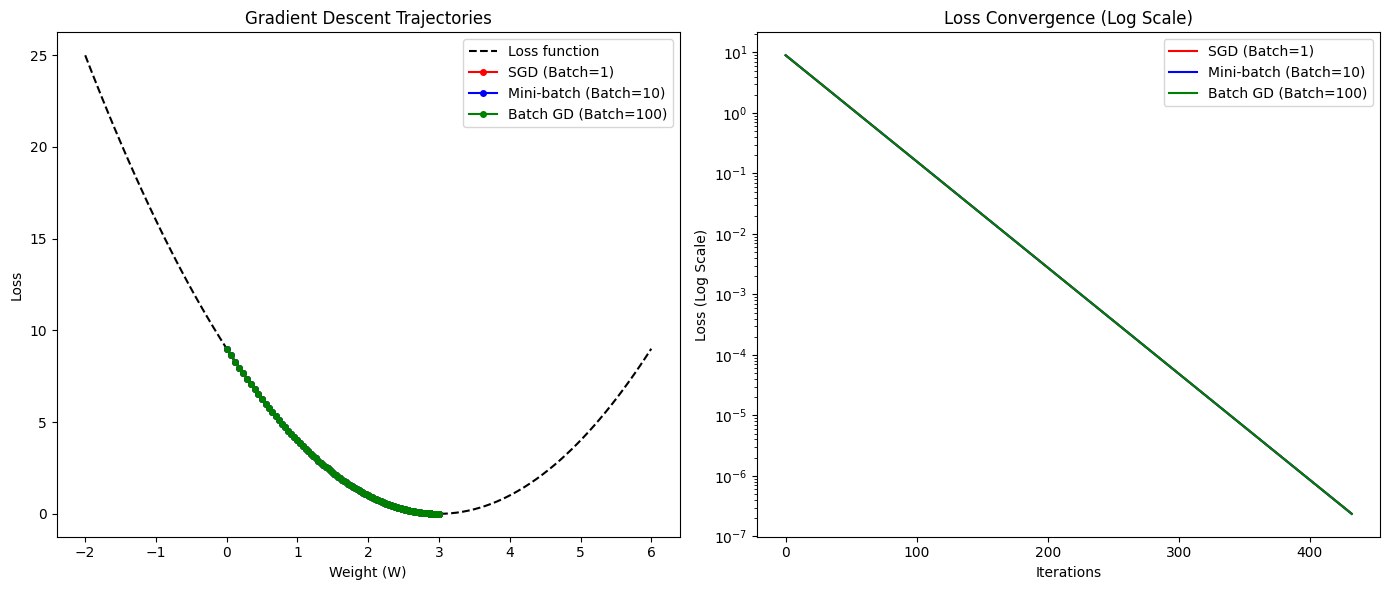


Gradient Descent with Complex Polynomial Loss:


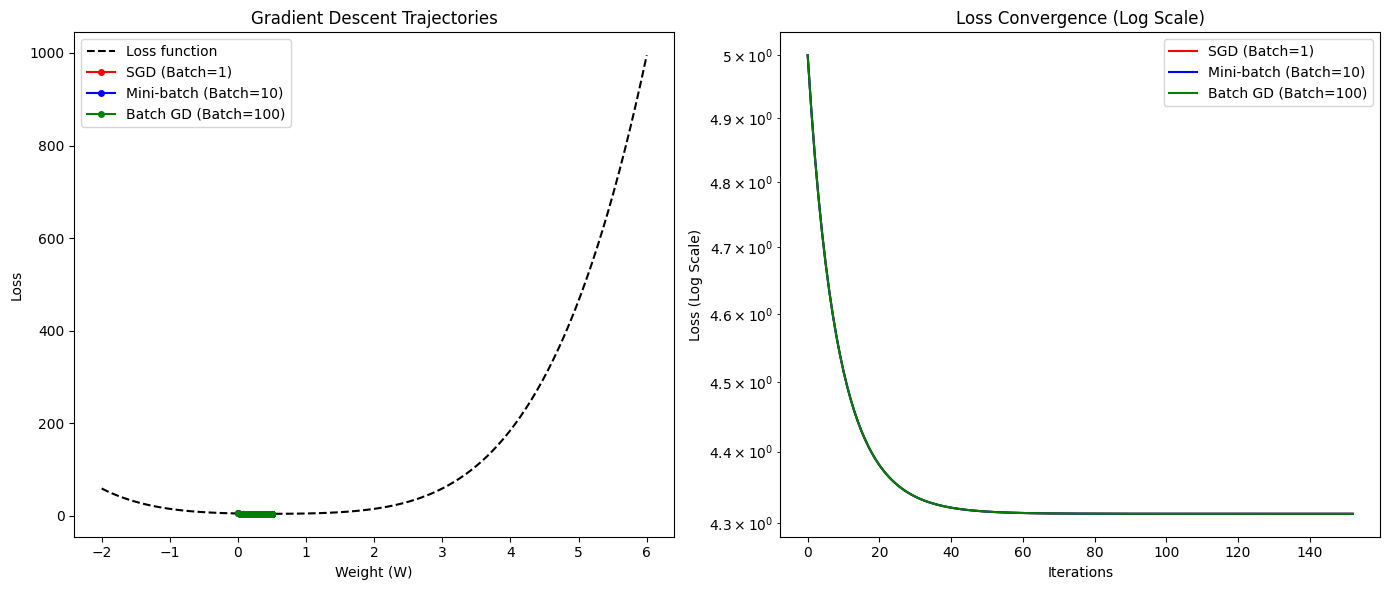

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class LossFunction:
    """
    A flexible class for defining loss functions and their gradients
    """
    @staticmethod
    def simple_quadratic(W):
        """Simple quadratic loss: (W - 3)^2"""
        return (W - 3) ** 2
    
    @staticmethod
    def simple_quadratic_gradient(W):
        """Gradient for simple quadratic loss"""
        return 2 * (W - 3)
    
    @staticmethod
    def complex_polynomial(W):
        """
        More complex polynomial loss function
        Example: f(W) = (W^4 - 2W^3 + 4W^2 - 3W + 5)
        """
        return W**4 - 2*W**3 + 4*W**2 - 3*W + 5
    
    @staticmethod
    def complex_polynomial_gradient(W):
        """Gradient for complex polynomial loss"""
        return 4*W**3 - 6*W**2 + 8*W - 3

def gradient_descent(loss_func, grad_func, 
                     batch_size, 
                     learning_rate=0.01, 
                     max_iterations=2000, 
                     W_init=0.0, 
                     n_samples=100, 
                     verbose=False,
                     tolerance=1e-8):
    """
    Perform gradient descent with customizable loss function and iteration limit
    
    Args:
        loss_func (callable): Loss function to minimize
        grad_func (callable): Gradient of the loss function
        batch_size (int): Number of samples in each batch
        learning_rate (float): Step size for weight updates
        max_iterations (int): Maximum number of iterations
        W_init (float): Initial weight value
        n_samples (int): Total number of samples to simulate
        verbose (bool): Print additional information if True
        tolerance (float): Stopping criterion for minimal change
    
    Returns:
        tuple: (trajectory of weights, trajectory of losses)
    """
    np.random.seed(42)  # For reproducibility
    W = W_init  # Initialize weight
    trajectory = [W]  # Store weight updates
    loss_trajectory = [loss_func(W)]  # Store loss values
    total_iterations = 0
    
    while total_iterations < max_iterations:
        # Randomize indices for batch selection
        indices = np.random.permutation(n_samples)
        
        for i in range(0, n_samples, batch_size):
            # Increment total iterations
            total_iterations += 1
            
            # Stop if max iterations reached
            if total_iterations >= max_iterations:
                break
            
            # Compute gradient and update weight
            grad = np.mean(grad_func(W))
            W_prev = W
            W -= learning_rate * grad
            
            # Store updated weight and its loss
            trajectory.append(W)
            current_loss = loss_func(W)
            loss_trajectory.append(current_loss)
            
            # Early stopping if change is minimal
            if np.abs(loss_func(W_prev) - current_loss) < tolerance:
                if verbose:
                    print(f"Early stopping at iteration {total_iterations}")
                break
        
        # Optional verbose output
        if verbose and (total_iterations % 100 == 0):
            print(f"Iteration {total_iterations}: Weight = {W:.4f}, Loss = {current_loss:.4f}")
        
        # Break if change is minimal
        if np.abs(loss_func(W_prev) - current_loss) < tolerance:
            break
    
    return np.array(trajectory), np.array(loss_trajectory)

def plot_gradient_descent_comparison(loss_func, grad_func, max_iterations=2000):
    """
    Visualize gradient descent trajectories with log-scale loss
    
    Args:
        loss_func (callable): Loss function to visualize
        grad_func (callable): Gradient of the loss function
        max_iterations (int): Maximum number of iterations
    """
    plt.figure(figsize=(14, 6))
    
    # Loss function landscape
    x_vals = np.linspace(-2, 6, 100)
    y_vals = [loss_func(x) for x in x_vals]
    plt.subplot(1, 2, 1)
    plt.plot(x_vals, y_vals, label="Loss function", color='black', linestyle='dashed')
    
    # Batch sizes to compare
    batch_sizes = [1, 10, 100]  # SGD, Mini-batch, Batch GD
    colors = ['red', 'blue', 'green']
    labels = ['SGD (Batch=1)', 'Mini-batch (Batch=10)', 'Batch GD (Batch=100)']
    
    # Plot trajectories
    for bs, color, label in zip(batch_sizes, colors, labels):
        traj, loss_traj = gradient_descent(loss_func, grad_func, bs, max_iterations=max_iterations)
        plt.plot(traj, loss_traj, 'o-', color=color, label=label, markersize=4)
    
    plt.xlabel("Weight (W)")
    plt.ylabel("Loss")
    plt.title("Gradient Descent Trajectories")
    plt.legend()
    
    # Log-scale loss convergence plot
    plt.subplot(1, 2, 2)
    for bs, color, label in zip(batch_sizes, colors, labels):
        traj, loss_traj = gradient_descent(loss_func, grad_func, bs, max_iterations=max_iterations)
        plt.semilogy(loss_traj, color=color, label=label)
    
    plt.xlabel("Iterations")
    plt.ylabel("Loss (Log Scale)")
    plt.title("Loss Convergence (Log Scale)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Demonstrate with two different loss functions
def main():
    print("Gradient Descent with Simple Quadratic Loss:")
    plot_gradient_descent_comparison(
        LossFunction.simple_quadratic, 
        LossFunction.simple_quadratic_gradient
    )
    
    print("\nGradient Descent with Complex Polynomial Loss:")
    plot_gradient_descent_comparison(
        LossFunction.complex_polynomial, 
        LossFunction.complex_polynomial_gradient
    )

if __name__ == "__main__":
    main()
